In [19]:
from model.lstm import LSTM
from data.generator import get_vocab_size, generate_batch
from utils.rnn_utils import get_mask, get_hidden_mask, reduce_lens, save_states, populate_first_output, build_first_output

import torch
from tqdm.notebook import trange
import seaborn as sns

In [2]:
MAX_ITER = 1000
HID_SIZE = 100
BS = 16
LR = 3e-4
DEVICE = 'cpu'

In [3]:
encoder = LSTM(
    input_size=get_vocab_size(),
    hidden_size=HID_SIZE,
    output_size=get_vocab_size(),
    batch_size=16,
).to(DEVICE)

decoder = LSTM(
    input_size=get_vocab_size(),
    hidden_size=HID_SIZE,
    output_size=get_vocab_size(),
    batch_size=16,
).to(DEVICE)

In [4]:
enc_dec_parameters = [p for p in encoder.parameters()] + [p for p in decoder.parameters()]

In [5]:
padded_samples_batch, padded_targets_batch, samples_len, targets_len = generate_batch(length=1, nesting=1, batch_size=BS)
padded_samples_batch, padded_targets_batch = padded_samples_batch.to(DEVICE), padded_targets_batch.to(DEVICE)

In [6]:
loss = torch.nn.CrossEntropyLoss(reduction='none')
opt = torch.optim.Adam(enc_dec_parameters, lr=LR)

In [16]:
def step(encoder, decoder, sample, target, samples_len, targets_len, loss, opt, device):
    opt.zero_grad()
    encoder.train()
    decoder.train()
    outputs = []
    first_output = {}
    h_dict, c_dict = {1: {}, 2: {}}, {1: {}, 2: {}}
    samples_len = samples_len.copy()
    targets_len = targets_len.copy()
    hid_size = encoder.h_t_1.size(1)
    
    for char_pos in range(sample.size(1)):
        hidden_mask = get_hidden_mask(samples_len, hid_size, device)
        output = encoder(sample[:, char_pos, :].squeeze(), hidden_mask)
        samples_len = reduce_lens(samples_len)
        h_dict, c_dict = save_states(encoder, h_dict, c_dict, samples_len)
        first_output = populate_first_output(output, samples_len, first_output)
    
    decoder.set_states(h_dict, c_dict)

    targets_len_copy = targets_len.copy()
    hidden_mask = get_hidden_mask(targets_len_copy, hid_size, device)
    output = decoder(build_first_output(first_output), hidden_mask)
    outputs.append(output)
    
    for char_pos in range(target.size(1) - 1):
        hidden_mask = get_hidden_mask(targets_len_copy, hid_size, device)
        output = decoder(target[:, char_pos, :].squeeze(), hidden_mask)
        targets_len_copy = reduce_lens(targets_len_copy)
        outputs.append(output)
        
    count_nonzero = 0
    cumulative_loss = 0
    loss_masks = []
    for char_pos, output in enumerate(outputs):
        loss_masks.append(get_mask(targets_len, device))
        targets_len = reduce_lens(targets_len)
        char_loss = loss(output, torch.argmax(target[:, char_pos, :].squeeze(), dim=1)) * loss_masks[-1]
        count_nonzero += (char_loss != 0).sum()
        cumulative_loss += torch.sum(char_loss)
    avg_loss = cumulative_loss / count_nonzero
    
    avg_loss.backward()
    opt.step()

    encoder.detach_states()
    decoder.detach_states()
    return avg_loss.item()

In [17]:
loss_values = []
for it in trange(MAX_ITER):
    loss_values.append(step(encoder, decoder, padded_samples_batch, padded_targets_batch, samples_len, targets_len, loss, opt, DEVICE))

  0%|          | 0/1000 [00:00<?, ?it/s]

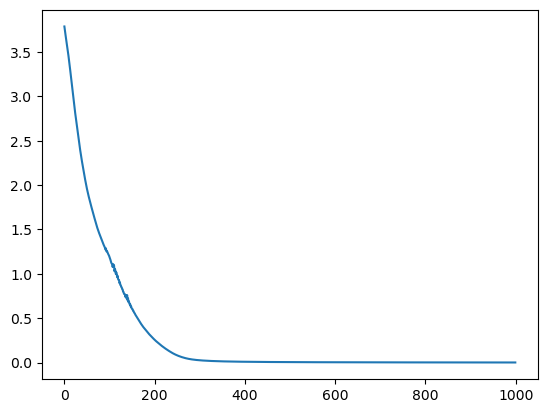

In [20]:
ax = sns.lineplot(loss_values)